# The Karplus-Strong Algorithm

The Karplus-Strong algorithm is a simple digital feedback loop with an internal buffer of $
M $  samples. The buffer is filled with a set of initial values and the loop, when running, produces an arbitraryly long output signal. Although elementary, the K-S loop can be used to synthesize interesting musical sounds as we will see in this notebook.

Let's start with a basic implementation of the K-S loop:

In [1]:
def KS_1(x, N):
    # given the initial buffer x, produce a N-sample output
    #  by concatenating identical copies of the buffer
    y = x
    while len(y) < N:
        # keep appending until we reach or exceed the required length
        y = np.append(y, x)
    # trim the excess
    y = y[0:N+1]
    return y

OK, let's try it out right away! Yet, however impatient we may be, we still need to do a few things. First we need to include the necessary Python libraries: 

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

In [3]:
plt.rcParams["figure.figsize"] = (14,4)

Then, since we're playing audio, we need to set the internal "clock" of the system, aka the sampling rate:

In [4]:
Fs = 16000 # 16 KHz sampling rate

With this sampling rate, since the period of the generated signal is equal to the length of the inital buffer, we will be able to compute the fundamental frequency of the resulting sound. For instance, if we init the K-S algorithm with a vector of 50 values, the buffer will fit $16000 / 50 = 320$ times in a second's worth of samples or, in other words, the resulting frequency will be 320Hz, which corresponds roughly to a E4 on a piano.

We still haven't talked about what to use as the initial values for the buffer. Well, the cool thing about K-S is that we can use pretty much anything we want; as a matter of fact, using random values will give you a totally fine sound. As a proof, consider this initial data set:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


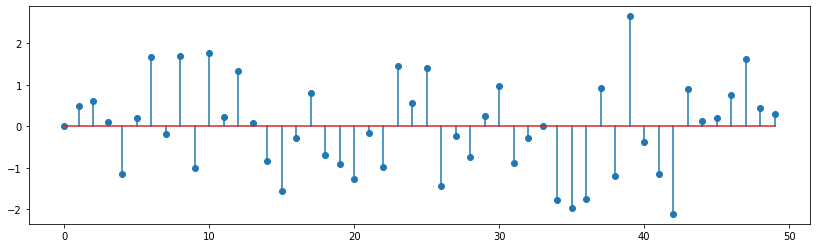

In [5]:
b = np.random.randn(50)
plt.stem(b);

Let's now generate a 2-second audio clip:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


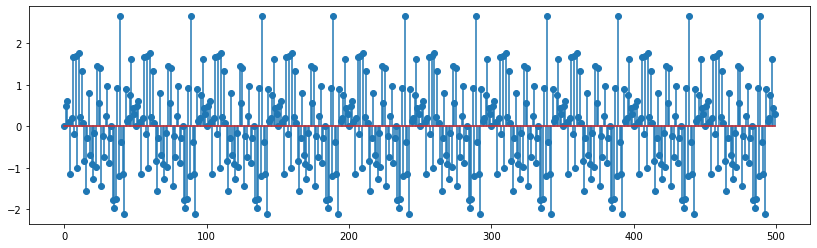

In [6]:
y = KS_1(b, Fs * 2)

# we can look at a few periods:
plt.stem(y[0:500]);

In [7]:
IPython.display.Audio(y, rate=Fs)

In [8]:
# let's play an octave lower: just double the initial buffer's length
IPython.display.Audio(KS_1(np.random.rand(100), Fs * 2), rate=Fs)

OK, so the K-S algorithm works! From the signal processing point of view, we can describe the system with the following block diagram (neglect the factor $\alpha$ for a moment)

![title](ks.png)

The output can be expressed as
$$
    y[n] = x[n] + y[n - M]
$$
assuming that the input is the finite-support signal
$$
x[n] = \begin{cases}
    0 & \mbox{for $n < 0$} \\
    b_n & \mbox{for $0 \le n < M$} \\
    0 & \mbox{for $n \ge M$}
  \end{cases}
$$

Let's implement the K-S algorithm as a signal processing loop

In [9]:
def KS_2(x, N):
    # length of the input
    M = len(x)
    # prepare the output
    y = np.zeros(N)
    # this is NOT an efficient implementation, but it shows the general principle
    # we assume zero initial conditions (y[n]=0 for n < 0)
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + (y[n-M] if n-M >= 0 else 0)
    return y

In [10]:
# it should still work
IPython.display.Audio(KS_2(np.random.rand(50), Fs * 2), rate=Fs)

By looking at block diagram we can see a simple modification that adds a lot of realism to the sound: by setting $\alpha$ to a value close to but less that one, we can introuce a decay in the note that produces guitar-like sounds:
$$
    y[n] = x[n] + \alpha y[n - M]
$$

In [11]:
def KS_3(x, N, alpha = 0.99):
    M = len(x)
    y = np.zeros(N)
    # 
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + alpha * (y[n-M] if n-M >= 0 else 0)
    return y

If we now plot the resulting K-S output, we can see the decaying envelope:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


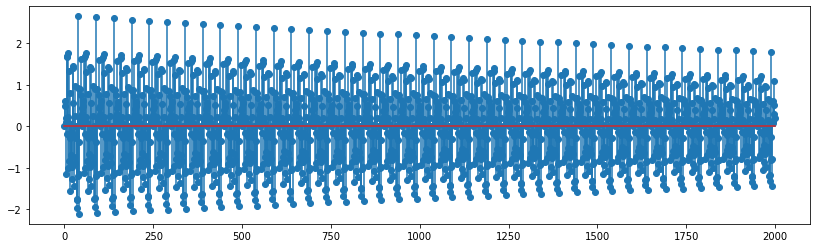

In [12]:
y = KS_3(b, Fs * 2)
plt.stem(y[0:2000]);

In [13]:
IPython.display.Audio(y, rate=Fs)

There is just one last detail (the devil's in the details, here as everywhere else). Consider the output of a dampened K-S loop; every time the initial buffer goes through the loop, it gets multiplied by $\alpha$ so that we can write
$$
  y[n] = \alpha^{\lfloor n/M \rfloor}x[n \mod N]
$$
(think about it and it will make sense). What that means is that the decay envelope is dependent on both $\alpha$ *and* $M$ or, in other words, the higher the pitch of the note, the faster its decay. For instance:

In [14]:
IPython.display.Audio(KS_3(np.random.rand(50), Fs * 2), rate=Fs)

In [15]:
IPython.display.Audio(KS_3(np.random.rand(10), Fs * 2), rate=Fs)

This is no good and therefore we need to compensate so that, if $\alpha$ is the same, the decay rate is the same. This leads us to the last implementation of the K-S algorithm:

In [16]:
def KS(x, N, alpha = 0.99):
    # we will adjust alpha so that all notes have a decay
    #  comparable to that of a buf len of 50 samples
    REF_LEN = 50
    M = len(x)
    a = alpha ** (float(M) / REF_LEN)
    y = np.zeros(N)
    # 
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + a * (y[n-M] if n-M >= 0 else 0)
    return y

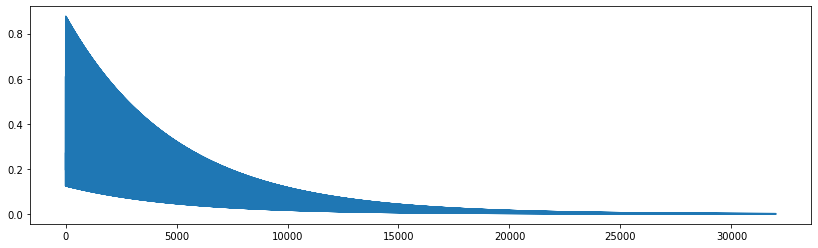

In [17]:
plot_ok = KS(np.random.rand(10), Fs * 2)
plt.plot(plot_ok)

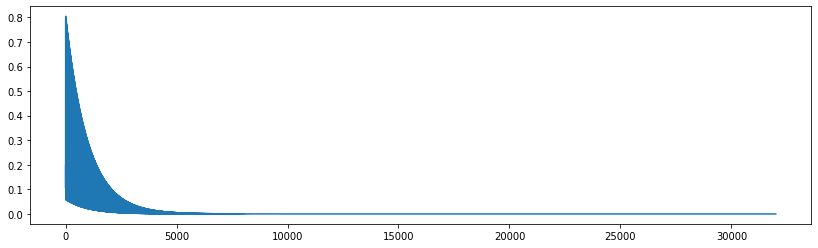

In [18]:
plot_nok = KS_3(np.random.rand(10), Fs * 2)
plt.plot(plot_nok)

In [19]:
IPython.display.Audio(KS(np.random.rand(50), Fs * 2), rate=Fs)

In [20]:
IPython.display.Audio(KS(np.random.rand(10), Fs * 2), rate=Fs)

## Playing Music!

Let's now play some cool guitar and, arguably, no guitar chord is as cool as the [opening chord of "A Hard Day's Night"](http://en.wikipedia.org/wiki/A_Hard_Day%27s_Night_%28song%29#Opening_chord), by The Beatles.

![title](hdn.png)

Much has been written about the chord (which, in fact, is made up of 2 guitars, one of which a 12-string, a piano and a bass) but to keep things simple, we will accept the most prevalent thesis which states that the notes are $D_3, F_3, G_3, F_4, A_4, C_5$ and $G_5$. To give it a "wider" feeling we will add another $D_2$ below. 

In Western music, where equal temperament is used, $A_4$ is the reference pitch at a frequency at 440Hz. All other notes can be computed using the formula $f(n) = A4 \times 2^{n/12}$ where $n$ is the number of half-tones between $A_4$ and the desired note. The exponent $n$ is positive if the note is above $A_4$ and negative otherwise.


Each note is generated using a separate Karplus-Strong algorithm. We try to mix the different "instruments" by assigning a
different gain to each note. Also, we sustain Paul's D note on the bass a bit longer by changing the corresponding decay factor.

In [21]:
def freq(note):
    # general purpose function to convert a note  in standard notation 
    #  to corresponding frequency
    if len(note) < 2 or len(note) > 3 or \
        note[0] < 'A' or note[0] > 'G':
        return 0
    if len(note) == 3:
        if note[1] == 'b':
            acc = -1
        elif note[1] == '#':
            acc = 1
        else:
            return 0
        octave = int(note[2])
    else:
        acc = 0
        octave = int(note[1])
    SEMITONES = {'A': 0, 'B': 2, 'C': -9, 'D': -7, 'E': -5, 'F': -4, 'G': -2}
    n = 12 * (octave - 4) + SEMITONES[note[0]] + acc
    f = 440 * (2 ** (float(n) / 12.0))
    #print note, f
    return f


def ks_chord(chord, N, alpha):
    y = np.zeros(N)
    # the chord is a dictionary: pitch => gain
    for note, gain in chord.items():
        # create an initial random-filled KS buffer the note
        x = np.random.randn(int(np.round(float(Fs) / freq(note))))
        y = y + gain * KS(x, N, alpha)
    return y  

In [22]:
# A Hard Day's Night's chord
hdn_chord = {
    'D2' : 2.2, 
    'D3' : 3.0, 
    'F3' : 1.0, 
    'G3' : 3.2, 
    'F4' : 1.0, 
    'A4' : 1.0, 
    'C5' : 1.0, 
    'G5' : 3.5,
}
    
IPython.display.Audio(ks_chord(hdn_chord, Fs * 4, 0.995), rate=Fs)

Close enough, no? (Check [here](https://upload.wikimedia.org/wikipedia/en/c/c4/A_Hard_Day's_Night_opening_chord.ogg)). You can now play around with other famous chords, try for instance the "Mystic Chord" by Scriabin, whose notes are $C_3, F^{\sharp}_3, B^{\flat}_3, E_4, A_4, D_5$.

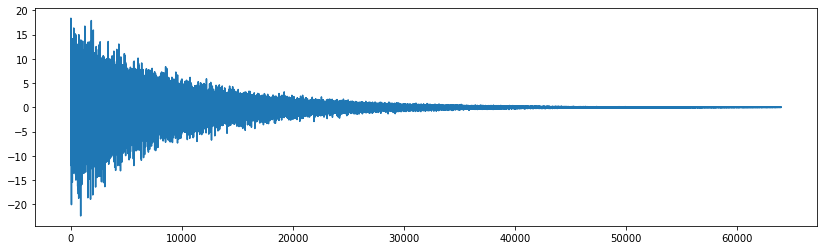

In [23]:
plot_ok1 = ks_chord(hdn_chord, Fs * 4, 0.995)
plt.plot(plot_ok1)

## Final Quiz

How would you describe what's happening here?

In [24]:
a = np.random.rand(100)
b = np.random.rand(80)
d = np.random.rand(40)
c = np.concatenate((a, a, a, a)) + np.concatenate((b, b, b, b, b)) + np.concatenate((d,d,d,d,d,d,d,d,d,d))

IPython.display.Audio(KS_1(c, Fs * 2), rate=Fs)

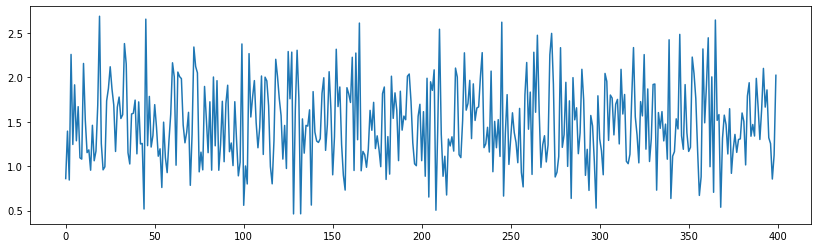

In [25]:
plt.plot(c)

In [26]:
from numpy import fft

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


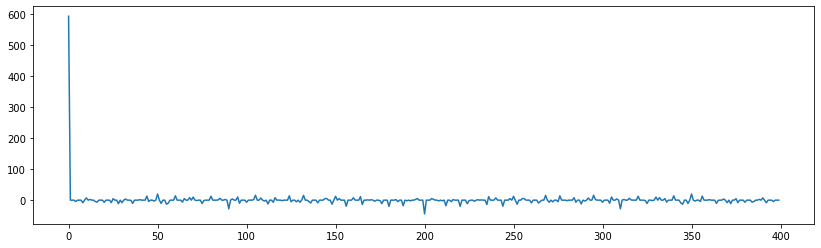

In [27]:
cfft = fft.fft(c)
plt.plot(cfft)

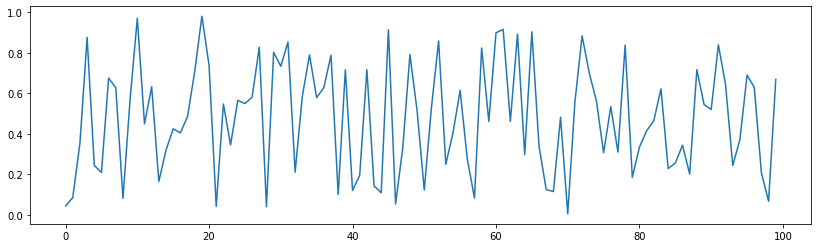

In [30]:
plt.plot(a)

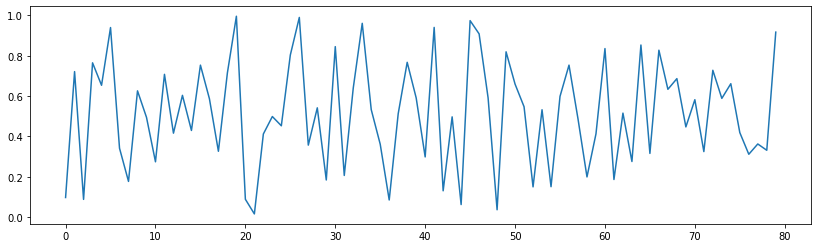

In [31]:
plt.plot(b)

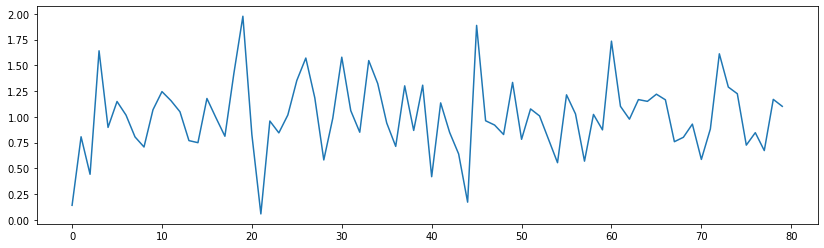

In [32]:
c2 = a[:80]+b
plt.plot(c2)

In [33]:
IPython.display.Audio(KS_1(c2, Fs * 2), rate=Fs)